# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as `hour.csv`.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the _training data_ only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (i.e., prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Identify the 3 target columns. Which of these target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and either pandas filtering by rows or [pandas qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest classification accuracy on the test set? Why is this? __[5 marks]__

# Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg
import math as math
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE

# Task 1: Read the _hourly_ data and split into training and test data.

##Start of Answer 1##

In [8]:
# Importing the dataset from the specified CSV file
df = pd.read_csv("data/hour.csv")

# Printing the shape of the DataFrame to show the number of rows and columns
print(df.shape)

# Displaying the first 10 rows of the dataset to get an initial view of the data
df.head(10)

(17379, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,0,1,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,0,2
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,1,2,3
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,8,6,14


In [10]:
# Define features (X) and target (y)
X = df.drop(columns=['cnt'])
y = df['cnt']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output sizes of splits
print(f"Training set size: {len(X_train)} observations")
print(f"Test set size: {len(X_test)} observations")

Training set size: 13903 observations
Test set size: 3476 observations


##End of Answer 1##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

##Start of Answer 2##

## Data Overview

Before delving further, it is essential to comprehend the dataset's quality and structure through the data overview stage. Verifying data types—which show whether variables are numeric or categorical—is part of this process. Finding missing values is essential since they may cause mistakes in modelling or analysis. Last but not least, summary statistics for numerical columns aid in assessing the scale, any outliers or anomalies, central tendencies (mean, median) and dispersion (standard deviation). To perform these checks, we used the `info()` function, which displays the column names, data types, and the number of non-null entries per column. This is followed by the `describe()` function, which generates summary statistics like mean, standard deviation, and quartiles for numerical features. Finally, `isnull().sum()` was used to count missing values for each column.

In [4]:
# Check the first few rows
print(X_train.info())

# Summary statistics
print(X_train.describe())

# Check for missing values
print(X_train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 13903 entries, 335 to 15795
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     13903 non-null  int64  
 1   dteday      13903 non-null  object 
 2   season      13903 non-null  int64  
 3   yr          13903 non-null  int64  
 4   mnth        13903 non-null  int64  
 5   hr          13903 non-null  int64  
 6   holiday     13903 non-null  int64  
 7   weekday     13903 non-null  int64  
 8   workingday  13903 non-null  int64  
 9   weathersit  13903 non-null  int64  
 10  temp        13903 non-null  float64
 11  atemp       13903 non-null  float64
 12  hum         13903 non-null  float64
 13  windspeed   13903 non-null  float64
 14  casual      13903 non-null  int64  
 15  registered  13903 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 1.8+ MB
None
            instant        season            yr          mnth            hr  \
count  13

The dataset makes preparation easier because it has 16 columns with no missing values. The dataset contains a number of categorical columns that need to be handled carefully, including `season`, `holiday`, and `weather`. Making sure things are properly encoded guarantees that machine learning models will find them useful. `Temp`, `atemp`, and `hum` are examples of continuous features that seem ready for analysis but may require scaling based on the model used. Data cleaning requires less work when there are no missing values, indicating that the data is complete.

## Feature Distributions

Understanding the underlying patterns and qualities of features can be achieved by investigating their distribution. Skewness, outliers, and range are checked for continuous features, as these could point to the necessity for scaling. The effectiveness of machine learning models, particularly those that are sensitive to feature magnitudes, is directly impacted by the distribution of variables, making this step crucial. We used the `hist()` method from pandas to generate histograms for all numeric columns. This enables simultaneous visualization of all numeric features, saving time compared to plotting each feature individually.

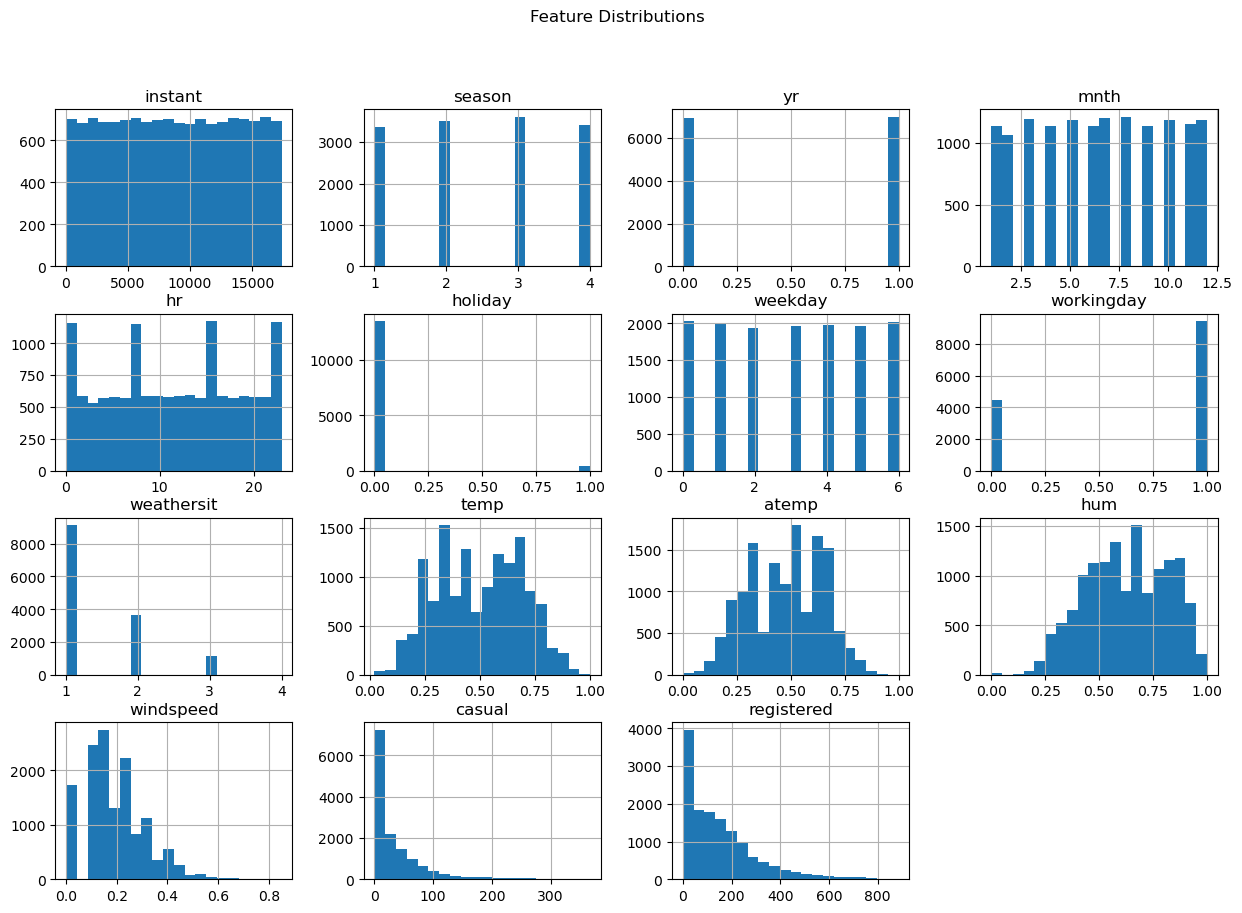

In [5]:
# Plot histograms for numerical features
X_train.hist(bins=20, figsize=(15, 10))
plt.suptitle('Feature Distributions')
plt.show()

The distributions reveal:
 - `temp` and `atemp`: Both show nearly normal distributions, suggesting that no transformations are required for these variables.
 - `hum`: This feature has a slight right skew, indicating that higher humidity levels are more frequent.
 - `windspeed`: The feature is highly skewed, with many observations concentrated near zero. This could be due to calm weather being the default state and might require logarithmic transformation to reduce its impact.

## Correlation Analysis

We can better grasp the relationships between various features and the target variable by using correlation analysis. Strong correlations between features and the target imply that the features may be crucial for target prediction. However, features that have a high degree of correlation with one another may be inapplicable, indicating they offer similar information. Certain machine learning models may have issues as a result of this duplication. A heatmap offers a clear, readable display of the correlation values, making it one of the greatest tools for visualising these relationships and comprehending how features interact. To perform this analysis, we first added the target variable `cnt` back to the training data using `train_data = X_train.copy()` followed by `train_data['cnt'] = y_train`. We also had to select only numeric columns for correlation so we selected only the columns which were of type `float64` or `int64`. Then, the `corr()` function from pandas computed the Pearson correlation coefficients between all numeric features. Finally, we visualized these correlations using a heatmap from Seaborn. Along with the heat map, we also created pairplots of important features to view the correlation between them on a graph.

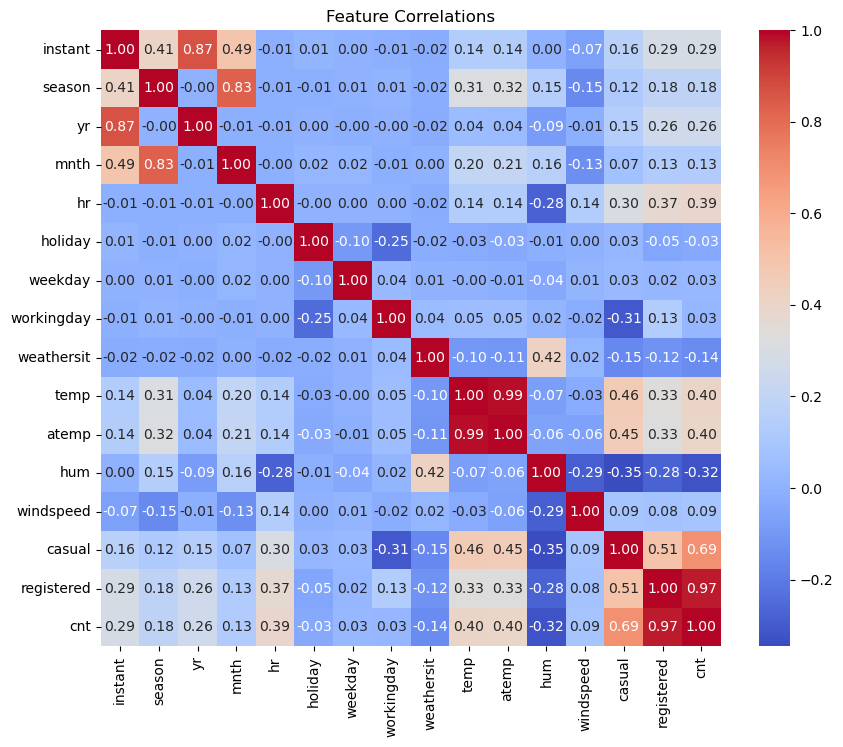

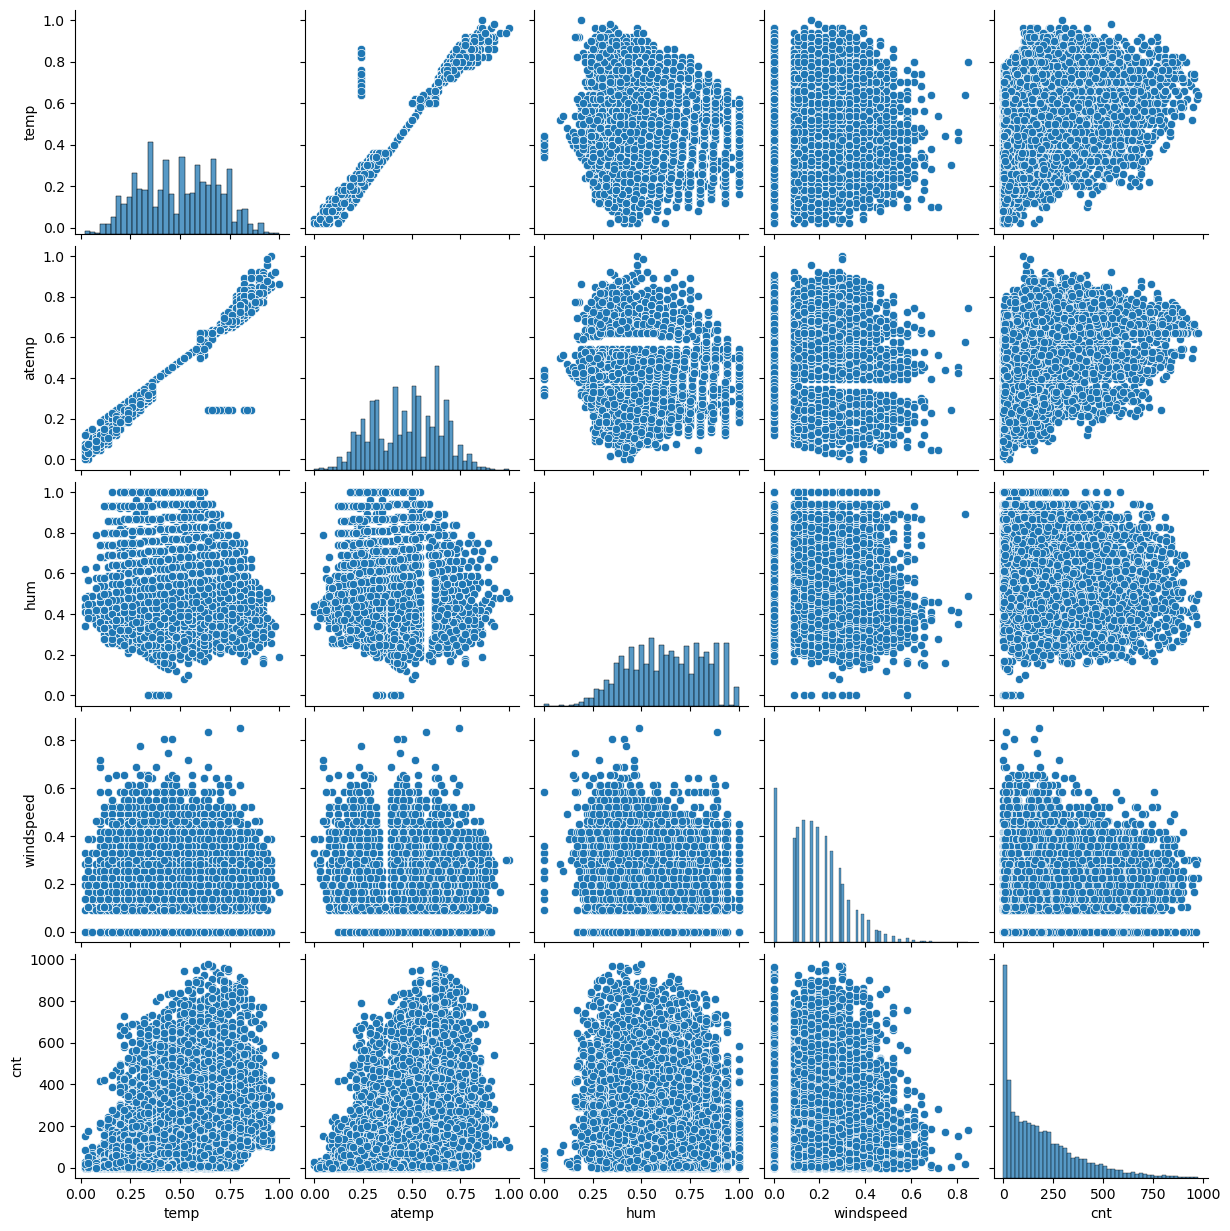

In [6]:
# Add the target back to X_train for analysis
train_data = X_train.copy()
train_data['cnt'] = y_train

# Select only numeric columns for correlation
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
train_data_numeric = train_data[numeric_columns]

# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_data_numeric.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlations')
plt.show()

# Pairplot for important features
important_features = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(train_data[important_features])
plt.show()

The heatmap and pairplots revealed:
 - `temp` and `atemp` are highly correlated with `cnt`, indicating that warmer weather increases bike rentals.
 - `registered` users have the highest correlation with `cnt`, highlighting the significant contribution of regular users to total rentals.
 - features like `windspeed` and `hum` have weak or negative correlations with `cnt`, suggesting limited direct influence.

## Temporal Patterns

In time-series or periodic data, temporal factors like the day of the week, season, and hour of the day frequently highlight important trends. Recognising peak usage periods and seasonal variations in bike rentals requires an understanding of these patterns. Boxplots were created using Seaborn’s `boxplot()` function to visualize the distribution of `cnt` (bike rentals) across temporal categories like `hr`, `season`, and `weekday`. These visualizations clearly highlight variations in rentals under different time-related conditions.

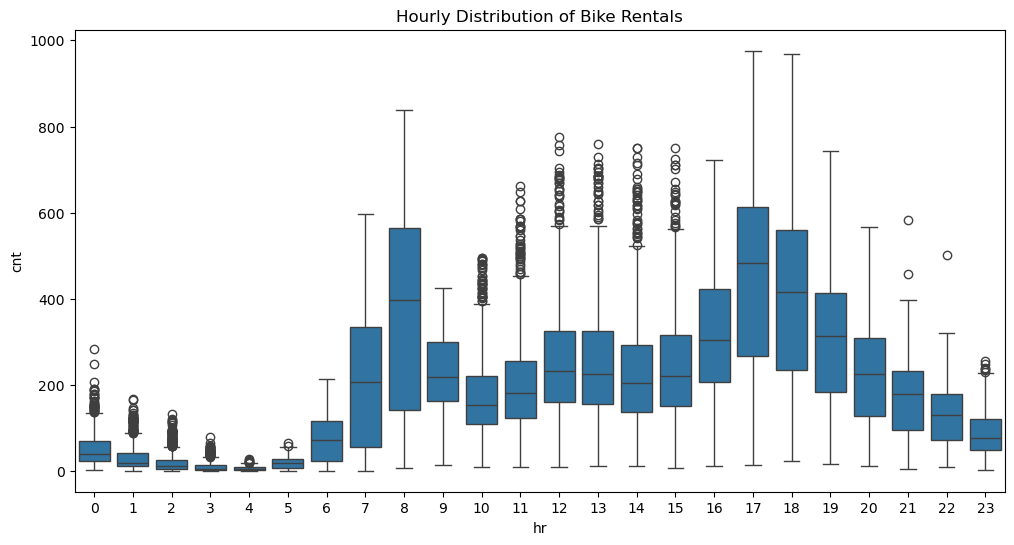

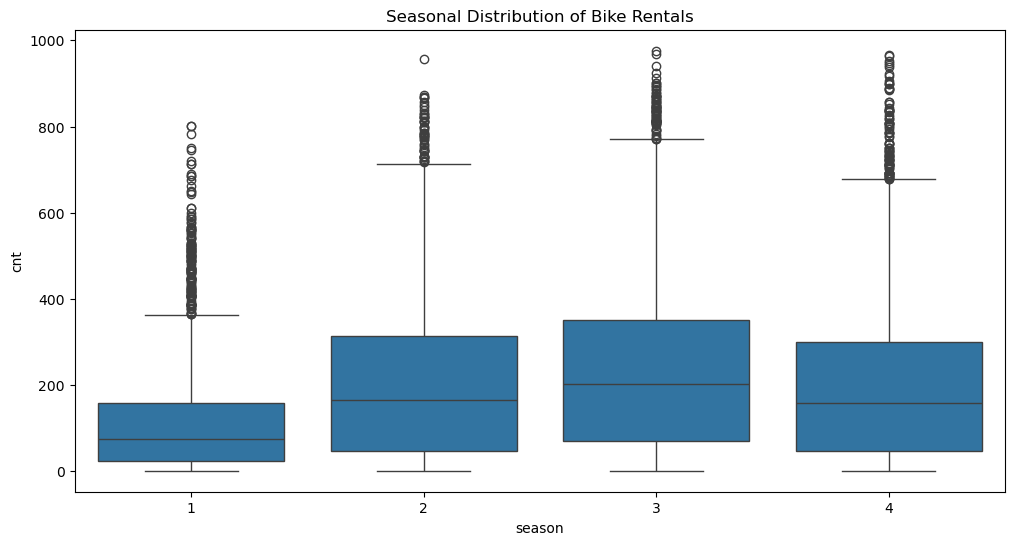

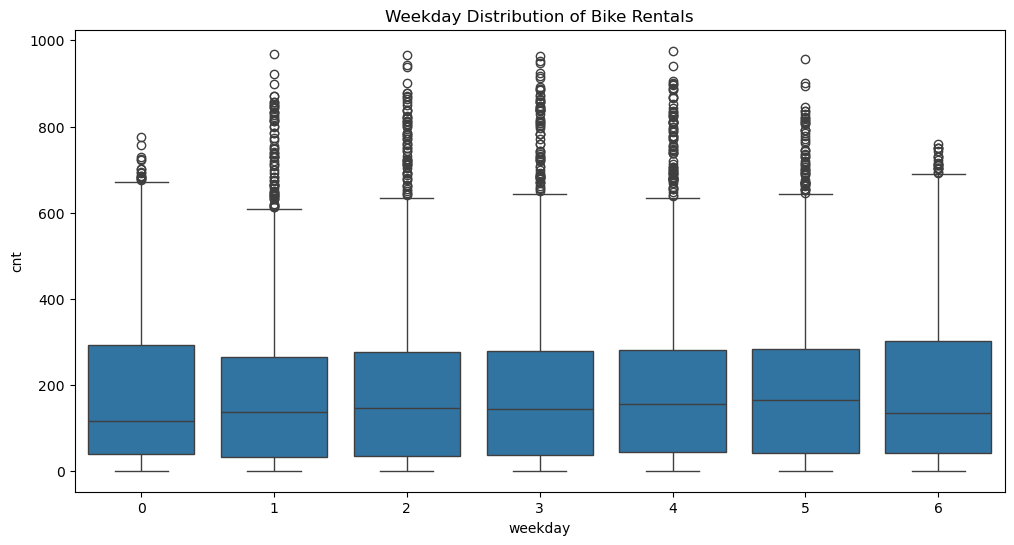

In [7]:
# Plot hourly trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='hr', y='cnt', data=train_data)
plt.title('Hourly Distribution of Bike Rentals')
plt.show()

# Plot seasonal trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='cnt', data=train_data)
plt.title('Seasonal Distribution of Bike Rentals')
plt.show()

# Plot weekday trends
plt.figure(figsize=(12, 6))
sns.boxplot(x='weekday', y='cnt', data=train_data)
plt.title('Weekday Distribution of Bike Rentals')
plt.show()


The boxplots show: 
 - Hourly Patterns: Rentals peak during morning and evening rush hours (e.g. 7–9 AM and 4–7 PM), possibly driven by people commuting to and from work. This trend is less pronounced on weekends, reflecting more leisure-oriented usage.
 - Seasonal Trends: Rentals are highest in spring and summer, with lower counts in fall and winter. This aligns with the expectation that warmer, favorable weather encourages outdoor activities.
 - Weekday Trends: Rentals are consistent across weekdays, but weekends see a slight increase in casual usage. These insights suggest that temporal features like `hr` and `season` should be included in models.

## Categorical Feature Analysis

Analyzing the impact of categorical features such as `holiday`, `weathersit`, and `workingday` on the target variable can reveal important behavioral patterns. Boxplots are particularly effective for comparing distributions of the target variable across categories. Boxplots for `cnt` against `holiday`, `weathersit`, and `workingday` were generated using Seaborn’s `boxplot()` function. Each plot provided a clear visualization of how rentals vary across these categorical features.

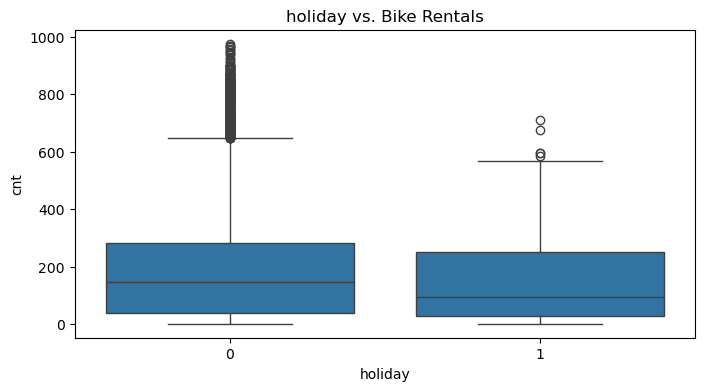

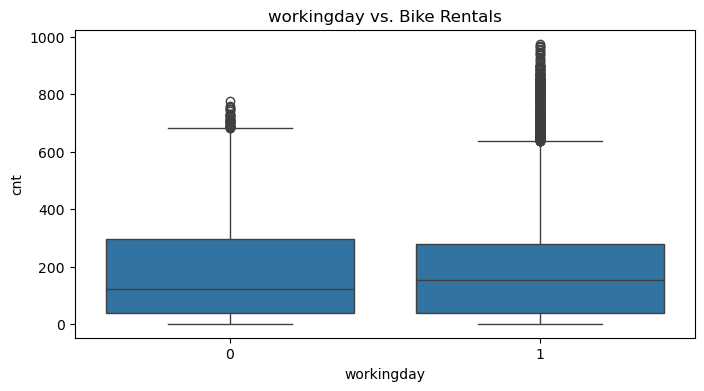

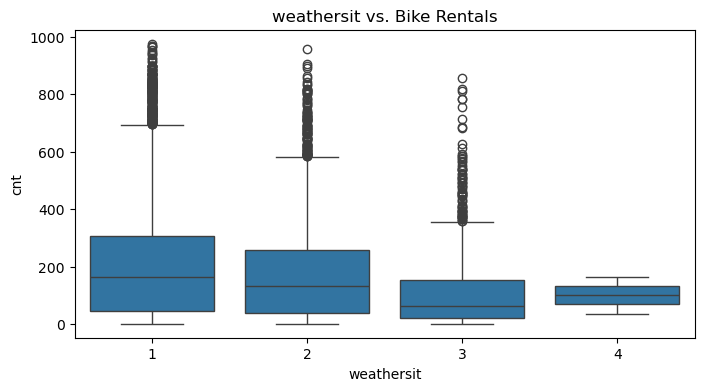

In [8]:
# List of categorical features to be analyzed
categorical_features = ['holiday', 'workingday', 'weathersit']

# Loop through each categorical feature and create a plot for each
for feature in categorical_features:
    plt.figure(figsize=(8, 4))    
    sns.boxplot(x=feature, y='cnt', data=train_data)    
    plt.title(f'{feature} vs. Bike Rentals')
    plt.show()

The boxplots show:
 - `holiday`: Bike rentals are lower on holidays, indicating reduced commuter activity, while casual use does not compensate for the decrease.
 - `workingday`:This feature reveals an interesting pattern — rentals are generally higher on working days compared to non-working days. This makes sense since the majority of bike rentals likely come from commuters who use bikes for transportation to work or school during the weekdays. On weekends, while there are still rentals, the demand seems to drop, potentially due to fewer people commuting and more people using bikes for recreational purposes.
 - `weathersit`: The impact of weather conditions on bike rentals is clear, with significantly fewer rentals during poor weather conditions (such as heavy rain or storms). This suggests that people are less likely to rent bikes during unfavorable weather, which aligns with general behavior for outdoor activities.

##End of Answer 2##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

##Start of Answer 3##

## Building the Model and Feature Selection

Feature selection is a critical step in building a machine learning model, especially when dealing with datasets that contain redundant, irrelevant, or potentially misleading features. The objective here is to identify the subset of features that contribute the most to predicting the total bike rental count (`cnt`) while avoiding overfitting and improving the model’s interpretability.

In this section, we perform Sequential Feature Selection (SFS) using a forward selection approach. This method systematically evaluates each feature's contribution to the model, adding one feature at a time to maximize the predictive performance, as measured by R^2

In [9]:
# Create the Linear Regression model
linearModel = LinearRegression()

# Remove irrelevant columns
if 'dteday' and 'casual' and 'registered' in X_train:
    X_train = X_train.drop(columns=['dteday', 'casual', 'registered'])

# Perform Sequential Feature Selection (SFS) with 10-fold cross-validation
sfs = SequentialFeatureSelector(linearModel, direction='forward', cv=KFold(n_splits=10), n_jobs=-1, scoring='r2')

# Fit the SFS on the training data
sfs.fit(X_train, y_train)

# Extract and display the names of the selected features
modelFeatures = list(X_train.columns[sfs.get_support()])
print("Model features:", modelFeatures)

Model features: ['season', 'yr', 'hr', 'holiday', 'temp', 'hum']


The selected features are the most predictive of bike rentals (`cnt`) and exclude columns like `casual`, `registered`, and `dteday` to prevent overfitting or leakage. For example, features such as `temp` (temperature) and `hum` (humidity) are likely correlated with bike rentals due to weather-dependent activity levels. By using SFS with 10-fold cross-validation, we ensure that the selected features generalize well to unseen data and avoid selecting spurious predictors.

## Model Training

After selecting the most relevant features using Sequential Feature Selection (SFS), the next step is to train the linear regression model using the selected features and evaluate its performance. This process includes assessing the model’s ability to generalize to unseen data using cross-validation, as well as computing key performance metrics such as R², Mean Squared Error (MSE), and Root Mean Squared Error (RMSE).

In [10]:
# Select the features identified by SFS
selected_features_train = X_train[modelFeatures]
selected_features_test = X_test[modelFeatures]

# Cross-validation to assess generalization performance
cv_scores = cross_val_score(linearModel, selected_features_train, y_train, cv = 10, scoring = 'r2')

# Train the linear regression model on the training set
linearModel.fit(selected_features_train, y_train)

# Make predictions on the test set
y_pred = linearModel.predict(selected_features_test)

# Compute evaluation metrics
r2 = r2_score(y_test, y_pred)

# Calculate Mean Squared Error for the test set
mse = mean_squared_error(y_test, y_pred)

print("10-fold cross-validation score: ", cv_scores)
print("Mean CV R^2 score: ", np.mean(cv_scores))
print("Test R^2 score: ", r2)
print("Test MSE: ", mse)
print("Test RMSE: ", math.sqrt(mse))

10-fold cross-validation score:  [0.36980432 0.42398599 0.35978621 0.3734978  0.37425703 0.40519203
 0.39317167 0.37287533 0.38837084 0.40154819]
Mean CV R^2 score:  0.3862489400385451
Test R^2 score:  0.3845737028079931
Test MSE:  19487.72684785736
Test RMSE:  139.59844858685702


The 10-fold cross-validation R² scores range from 0.36 to 0.42, with a mean CV R² score of 0.386. This indicates that the model explains approximately 38.6% of the variance in the target variable (`cnt`) across the training folds. While the scores are consistent, they suggest that the model has limited predictive power and might be missing important patterns or relationships in the data. The test R² score is 0.385, which aligns closely with the mean CV R² score. This consistency indicates that the model generalizes well and avoids overfitting. However, explaining only ~38.5% of the variance on the test set implies that the model is not capturing all the important factors driving bike rentals. The Mean Squared Error (MSE) is 19,487.73, and the Root Mean Squared Error (RMSE) is 139.60. The RMSE indicates that, on average, the model's predictions are off by about 139 rentals, which is significant given the typical scale of `cnt`.

## Visualizing the Model

This visualization helps evaluate the performance of the regression model by plotting the actual (y_test) and predicted (y_pred) values in sorted order, making it easier to compare how closely the predictions match the true data. Residuals, or the differences between the actual and predicted values, are highlighted using vertical lines, with longer lines indicating larger discrepancies. This allows us to assess the model's accuracy and identify any systematic errors or biases, such as consistent over- or under-predictions in certain ranges.

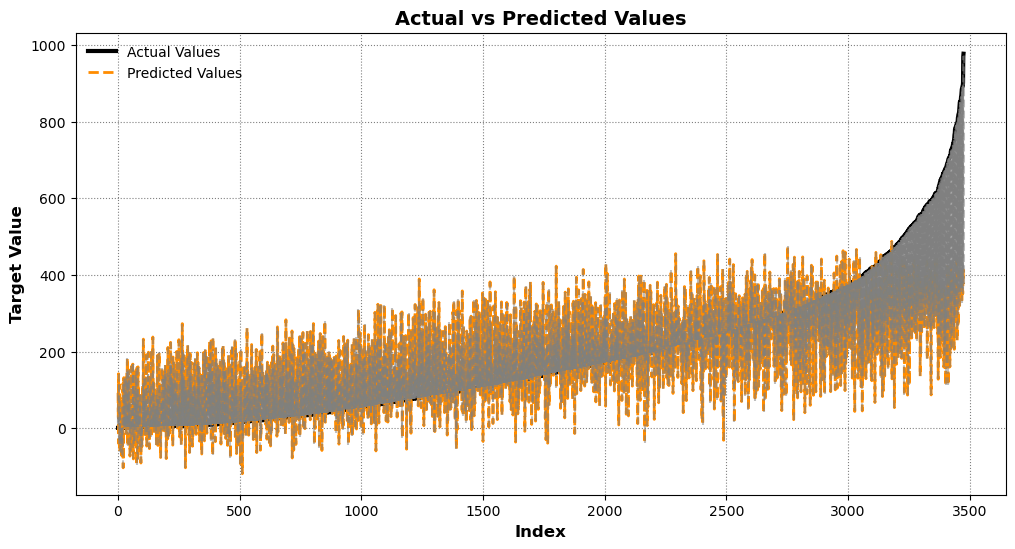

In [11]:
# Sort indices based on the actual test values
indices_sorted = np.argsort(y_test)

# Create sorted arrays of actual and predicted test values
sorted_actual = np.array(y_test)[indices_sorted]
sorted_predictions = np.array(y_pred)[indices_sorted]

# Set up the plot dimensions
plt.figure(figsize=(12, 6))

# Plot the sorted actual and predicted values
plt.plot(sorted_actual, label="Actual Values", color="black", linestyle='-', linewidth=3)
plt.plot(sorted_predictions, label="Predicted Values", color="darkorange", linestyle='--', linewidth=2)

# Add vertical lines for residuals
for i in range(len(sorted_actual)):
    plt.vlines(x=i, ymin=sorted_predictions[i], ymax=sorted_actual[i], color="gray", linestyle="--", alpha=0.5)

# Add labels
plt.xlabel("Index", fontsize=12, fontweight='bold')
plt.ylabel("Target Value", fontsize=12, fontweight='bold')

# Add title
plt.title("Actual vs Predicted Values", fontsize=14, fontweight='bold')

# Display legend
plt.legend(loc="upper left", fontsize=10, frameon=False)

# Show the plot with grid lines for better visibility
plt.grid(True, linestyle=':', color='black', alpha=0.5)

# Display the plot
plt.show()

From this plot, we can interpret that the predicted values follow the general trend of the actual values, meaning that the model is capturing the overall pattern of the data. This suggests that the model has a reasonable understanding of the underlying relationships between the features and the target variable. However, despite the overall trend being similar, there are noticeable differences between the actual and predicted values. These differences, represented by the gray residual lines, highlight where the model’s predictions deviate from the true values.

##End of Answer 3##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

In this section, we aim to evaluate the performance of a linear regression model on three different targets: `cnt`, `casual`, and `registered`, which represent different types of demand in the dataset. The goal is to assess how well the model predicts each target by performing feature selection and evaluating the model’s performance using several metrics. We will use Sequential Feature Selection (SFS) to identify the most relevant features for each target, helping to simplify the model by eliminating irrelevant or redundant features. For each target, the linear regression model will be trained on the selected features, and its performance will be assessed using R² (R-squared), MSE (Mean Squared Error), RMSE (Root Mean Squared Error), and Mean CV R² calculated from cross-validation. These metrics will help determine how accurately the model predicts the target variable. After evaluating all three targets, we will compare the results to identify the easiest target to predict, providing insights into which type of demand is more predictable based on the features available.

In [12]:
test_data = X_test.copy()
test_data['cnt'] = y_test

# List of target columns
target_columns = ['cnt', 'casual', 'registered']

# Create a dictionary to store results
results = {}

# Loop through each target column and evaluate the model's performance
for target in target_columns:
    print(f"Evaluating model for target: {target}")
    
    # Extract the target values from y_train and y_test
    if target == 'cnt':
        y_train_target = y_train
        y_test_target = y_test
    elif target == 'casual':
        y_train_target = train_data['casual']
        y_test_target = test_data['casual'] 
    elif target == 'registered':
        y_train_target = train_data['registered'] 
        y_test_target = test_data['registered'] 
    
    # Perform the SFS for the target column to select features
    sfs.fit(X_train, y_train_target)
    modelFeatures = list(X_train.columns[sfs.get_support()])
    
    # Select the features identified by SFS
    selected_features_train = X_train[modelFeatures]
    selected_features_test = X_test[modelFeatures]
    
    # Cross-validation to assess generalization performance for the target
    cv_scores = cross_val_score(linearModel, selected_features_train, y_train_target, cv=10, scoring='r2')
    
    # Train the model on the selected features
    linearModel.fit(selected_features_train, y_train_target)
    
    # Make predictions on the test set
    y_pred_target = linearModel.predict(selected_features_test)
    
    # Compute evaluation metrics
    r2 = r2_score(y_test_target, y_pred_target)
    mse = mean_squared_error(y_test_target, y_pred_target)
    rmse = math.sqrt(mse)
    
    # Store results for comparison
    results[target] = {
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse,
        'Mean CV R²': np.mean(cv_scores)
    }
    
    # Print results for each target
    print(f"  R²: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  Mean CV R²: {np.mean(cv_scores):.4f}")
    print("-" * 40)

# Find the easiest target to predict based on R², MSE, and RMSE
easiest_target = max(results, key=lambda x: results[x]['R²']) 
print(f"The easiest target to predict is: {easiest_target}")

Evaluating model for target: cnt
  R²: 0.3846
  MSE: 19487.7268
  RMSE: 139.5984
  Mean CV R²: 0.3862
----------------------------------------
Evaluating model for target: casual
  R²: 0.4519
  MSE: 1259.3905
  RMSE: 35.4879
  Mean CV R²: 0.4515
----------------------------------------
Evaluating model for target: registered
  R²: 0.3219
  MSE: 14969.0910
  RMSE: 122.3482
  Mean CV R²: 0.3285
----------------------------------------
The easiest target to predict is: casual


The model performance across different targets (`cnt`, `casual`, and `registered`) reveals insightful patterns about the difficulty of predicting each target variable in the dataset. Here, we evaluate the predictive performance of the model using key metrics such as R², Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) for each target. From the above evaluation, it is evident that `casual` riders is the easiest target to predict in this dataset, based on the R², MSE, and RMSE metrics. The model achieves the highest R² and the lowest MSE and RMSE for the casual riders target, which suggests that the features included in the model are more predictive of casual rider counts than of total or registered rider counts. In contrast, predicting `cnt` and `registered` is more challenging, likely due to the complex and potentially less predictable interactions between casual and registered riders, as well as the impact of other external factors.

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label.

##Start of Answer 5##

Grouping the `casual` demand into quartiles simplifies the analysis of this continuous target variable by dividing it into four distinct categories: low, moderate-low, moderate-high, and high demand. These quartiles are defined using the 25th, 50th, and 75th percentiles of the data. This process reduces the complexity of analyzing the full range of continuous values, enabling a clearer focus on broad demand categories. Importantly, dividing the data into quartiles ensures a balanced distribution across the groups, which helps maintain fairness in training machine learning models and prevents skewed predictions due to over-representation of certain ranges.

In [13]:
# Calculate the 25th, 50th, and 75th percentiles of the 'casual' column
q1, q2, q3 = df['casual'].quantile([0.25, 0.5, 0.75])

print(f"Quartile intervals: \n25th percentile (Q1): {q1}\n50th percentile (Q2): {q2}\n75th percentile (Q3): {q3}")

# Use pandas' qcut to group the 'casual' column into quartiles
df['casual_demand'] = pd.qcut(
    df['casual'],
    q = [0, 0.25, 0.5, 0.75, 1],
    labels = ['Low', 'Moderate-Low', 'Moderate-High', 'High']
)

print(df[['casual', 'casual_demand']].head(13))

Quartile intervals: 
25th percentile (Q1): 4.0
50th percentile (Q2): 17.0
75th percentile (Q3): 48.0
    casual  casual_demand
0        3            Low
1        8   Moderate-Low
2        5   Moderate-Low
3        3            Low
4        0            Low
5        0            Low
6        2            Low
7        1            Low
8        1            Low
9        8   Moderate-Low
10      12   Moderate-Low
11      26  Moderate-High
12      29  Moderate-High


The quartiles calculated here divide the demand for `casual` rentals into clear intervals based on the data’s distribution. For the given dataset, the 25th, 50th, and 75th percentiles are identified as 4.0, 17.0, and 48.0, respectively. This categorization helps provide a clear picture of how demand is distributed across the dataset.

##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles.

##Start of Answer 6

Before training the classification models to predict the demand quartiles, we need to preprocess the data to ensure all numerical features are on a comparable scale. We will use StandardScaler, a commonly used scaling method, to standardize the numerical features to have a mean of 0 and a standard deviation of 1.

Additionally, we will align the target labels (`y_train_quartiles` and `y_test_quartiles`) with the scaled training and test datasets. This ensures that the target quartiles correspond correctly to their respective observations in the training and test sets.

In [14]:
# Initialize the StandardScaler
scaler = StandardScaler()

X_test = X_test[X_train.columns]

# Scale numerical features in the training and test sets
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=[np.number]))
X_test_scaled = scaler.fit_transform(X_test.select_dtypes(include=[np.number]))

# Map the quartile target labels for the training and test datasets
y_train_quartiles = df.loc[y_train.index, "casual_demand"]
y_test_quartiles = df.loc[y_test.index, "casual_demand"]

# Display the first few rows of the training quartile labels for verification
y_train_quartiles.head()

335     Moderate-High
7035             High
8051              Low
2133             High
8485              Low
Name: casual_demand, dtype: category
Categories (4, object): ['Low' < 'Moderate-Low' < 'Moderate-High' < 'High']

The output confirms that the demand quartile labels (`casual_demand`) have been successfully mapped to their respective training data indices. The labels include the categories 'Low', 'Moderate-Low', 'Moderate-High', and 'High', representing the demand levels in increasing order based on the quartile intervals. The successful mapping of labels ensures that the targets align with the corresponding features, avoiding any data mismatches. This step is crucial for reliable training and evaluation of classification models. The dataset is now ready for applying forward feature selection and training the classification models to predict these quartile-based demand levels.

### Classification 1

In this section, we will perform feature selection using the Sequential Feature Selector (SFS) to identify the most relevant features for predicting the casual demand quartiles using a K-Nearest Neighbors (KNN) model.
We will use the SequentialFeatureSelector from the sklearn library to select features based on their performance in predicting the demand quartiles. The goal is to build a model that accurately predicts demand categories (Low, Moderate-Low, Moderate-High, High) based on the selected features.

In [15]:
# Initialize K-Nearest Neighbors (KNN) classifier model
knn_model = KNeighborsClassifier()

# Apply Sequential Feature Selector (SFS) with KNN model
sfs_knn = SequentialFeatureSelector(knn_model, direction='forward', cv=KFold(n_splits=10), scoring='accuracy')

# Fit the SFS model to the training data
sfs_knn.fit(X_train_scaled, y_train_quartiles)

# Extract the indices of the selected features from the SFS model
selected_indices = sfs_knn.get_support()

# Retrieve the names of the selected features using the selected indices
selected_features_knn = X_train.select_dtypes(include=np.number).columns[selected_indices]

# Train the KNN model on the selected features from the training data
knn_model.fit(X_train_scaled[:, sfs_knn.get_support()], y_train_quartiles)

# Make predictions on the test set using the selected features
y_pred_knn = knn_model.predict(X_test_scaled[:, sfs_knn.get_support()])

# Output the classification report
print(classification_report(y_test_quartiles, y_pred_knn))


               precision    recall  f1-score   support

         High       0.39      0.46      0.42       823
          Low       0.35      0.42      0.38       934
Moderate-High       0.30      0.25      0.27       844
 Moderate-Low       0.31      0.24      0.27       875

     accuracy                           0.34      3476
    macro avg       0.34      0.34      0.34      3476
 weighted avg       0.34      0.34      0.34      3476



The KNN model's classification performance shows that it struggles to differentiate between the demand quartiles effectively. The KNN model, despite using feature selection, is not performing well for this classification task. The relatively low accuracy and poor precision/recall values suggest that either additional feature engineering is required, or a different modeling technique might be better suited for predicting the demand quartiles.

### Classification 2

In this section, we are going to train a Logistic Regression model on the data to classify the quartiles of the demand (`casual_demand`) into four categories: High, Low, Moderate-High, and Moderate-Low. Logistic Regression is chosen as the classification method because it is a widely used model for multiclass classification tasks and provides coefficients that can easily be interpreted. We will also apply Recursive Feature Elimination (RFE) to select the most important features that best predict the target variable, reducing the dimensionality and improving model efficiency.

In [33]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000, solver='lbfgs')

# Apply Recursive Feature Elimination (RFE) to select the top features
rfe = RFE(estimator=log_reg_model, n_features_to_select=5)
rfe.fit(X_train_scaled, y_train_quartiles)

# Retrieve the selected features
selected_features_log_reg = X_train.select_dtypes(include=np.number).columns[rfe.support_]

# Fit Logistic Regression model with the selected features
log_reg_model.fit(X_train_scaled[:, rfe.support_], y_train_quartiles)

# Predict on the test set
y_pred_log_reg = log_reg_model.predict(X_test_scaled[:, rfe.support_])

# Output classification report
print(classification_report(y_test_quartiles, y_pred_log_reg))

               precision    recall  f1-score   support

         High       0.64      0.73      0.68       823
          Low       0.61      0.76      0.67       934
Moderate-High       0.44      0.40      0.42       844
 Moderate-Low       0.41      0.28      0.33       875

     accuracy                           0.54      3476
    macro avg       0.52      0.54      0.53      3476
 weighted avg       0.52      0.54      0.53      3476



The Logistic Regression model performed relatively well on the classification task, achieving an overall accuracy of 54%. The classification report provides a detailed breakdown of the model's performance for each demand quartile. Overall, the model's macro average F1-score of 0.53 and weighted average F1-score of 0.53 indicate a decent but not exceptional performance, with room for improvement. The model's ability to correctly predict the high and low demand quartiles may be due to clearer distinctions between these categories, while the moderate demand quartiles might require further model refinement or additional features to achieve higher accuracy.

##End of Answer 6##

# Task 7: Does regression or classification provide the best classification accuracy on the test set? Why?

##Start of Answer 7

When comparing different machine learning procedures for classification tasks, the performance can vary based on several factors, including the type of model, the nature of the data, and the specific algorithm used. In this case, we applied both Logistic Regression and K-Nearest Neighbors (KNN) to a classification problem, aiming to predict demand quartiles. In general, Logistic Regression is likely to outperform KNN in classification tasks when the decision boundaries are linear, when feature selection is applied, and when handling class imbalances. Logistic Regression’s ability to generalize better, coupled with techniques like regularization and feature selection, typically leads to higher classification accuracy compared to KNN, especially in high-dimensional or noisy datasets.

##End of Answer 7##